# Statistical Research

### 1) Download libraries and modules

In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import spearmanr, kendalltau
from pathlib import Path
from typing import List, Optional
from fitter import Fitter
import seaborn as sns

In [2]:
def project_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for candidate in [p, *p.parents]:
        if (candidate / "pyproject.toml").exists():
            return candidate
    return p

### 2) Download train data

We first make data usable by downloading it into a Polars dataframe:

In [ ]:
# Get the paths (for interchange between Windows and MacOS)

root_path = project_root()

# Dowload train data related files
train_data = pd.read_csv(root_path / "data" / "train.csv")
train_data_new = pd.read_csv(root_path / "data" / "train_new.csv") # in windows, use "\"

# Merge both csvs of train data
merged_data = pd.concat([train_data, train_data_new], axis=0)
columns = [col for col in merged_data.columns if col not in ['Y1', 'Y2']] + ['Y1', 'Y2']
merged_data = merged_data[columns]
merged_data = merged_data.set_index("time")
merged_data.to_csv(root_path / "data" / "full_train_data.csv")
train_data_new = pd.read_csv(root_path / "data" / "full_train_data.csv")
train_data = pl.DataFrame(merged_data)
print("TRAIN DATA\n")
print(train_data.head())

# Take a look at what the test data looks like
print("\nTEST DATA\n")
test_data = pl.read_csv(root_path / "data" / "test.csv")
print(test_data.head())

TRAIN DATA

shape: (5, 18)
┌───────────┬───────────┬───────────┬───────────┬───┬──────┬──────┬───────────┬───────────┐
│ A         ┆ B         ┆ C         ┆ D         ┆ … ┆ O    ┆ P    ┆ Y1        ┆ Y2        │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---  ┆ ---  ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64  ┆ f64  ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════╪══════╪═══════════╪═══════════╡
│ 0.207366  ┆ -0.159951 ┆ -0.634176 ┆ -0.580962 ┆ … ┆ null ┆ null ┆ -0.935902 ┆ -0.310081 │
│ 0.188828  ┆ -0.265508 ┆ 0.042143  ┆ -0.550442 ┆ … ┆ null ┆ null ┆ -0.089707 ┆ -0.305374 │
│ -0.144261 ┆ -0.577142 ┆ -0.214634 ┆ -0.747391 ┆ … ┆ null ┆ null ┆ -0.077855 ┆ -0.631485 │
│ 0.208982  ┆ -0.310449 ┆ 0.513708  ┆ -0.562868 ┆ … ┆ null ┆ null ┆ 0.941271  ┆ -0.535212 │
│ 0.09332   ┆ -0.358156 ┆ 0.173188  ┆ -0.687296 ┆ … ┆ null ┆ null ┆ -0.039582 ┆ -0.490561 │
└───────────┴───────────┴───────────┴───────────┴───┴

### 3) Visualize Relationship between Targets and Explanatory Variables

Plot the features dependency with the variables into scatter plot grids:

In [4]:
def plot_grid_vs_target(target: np.ndarray, label: str, num_rows: int, num_cols: int, columns_to_plot: List[str], colour: str):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = np.atleast_1d(axes).ravel()
    corr_dict = {}
    y = np.asarray(target, dtype=float)

    for i, col in enumerate(columns_to_plot):
        ax = axes[i]
        x = np.asarray(train_data[col], dtype=float)

        m = np.isfinite(x) & np.isfinite(y)
        corr = np.corrcoef(x[m], y[m])[0, 1] if m.any() else np.nan

        corr_dict[col] = corr

        ax.scatter(x[m], y[m], alpha=0.5, color=colour)
        ax.set_title(f"{col} vs {label}\ncorr={corr:.4f}" if np.isfinite(corr) else f"{col} vs {label}\ncorr=nan")
        ax.set_xlabel(col)
        ax.set_ylabel(label)

    # remove unused axes (if grid > number of features)
    for j in range(len(columns_to_plot), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"Features vs {label}", y=0.995, fontsize=16)
    fig.tight_layout()
    plt.show()
    return corr_dict

def superpose_grids(targets: List[np.ndarray], labels: List[str], num_rows: int, num_cols: int, columns_to_plot: List[str], colours: List[str]):

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(columns_to_plot):
        ax = axes[i]
        x = np.asarray(train_data[col].to_numpy(), dtype=float).ravel()
        corrs = [] 

        for num, target in enumerate(targets):
            y = np.asarray(target, dtype=float).ravel()
            m = np.isfinite(x) & np.isfinite(y)
            if m.sum() >= 2 and np.std(x[m]) > 0 and np.std(y[m]) > 0:
                c = np.corrcoef(x[m], y[m])[0, 1]
            else:
                c = np.nan

            corrs.append(c)
            ax.scatter(x[m], y[m], alpha=0.5, label=labels[num], color=colours[num])

        corr_txt = "  |  ".join(
            f"corr({lbl})={c:.4f}" if np.isfinite(c) else f"corr({lbl})=nan"
            for lbl, c in zip(labels, corrs)
        )
        ax.set_title(f"{col} vs targets\n{corr_txt}")
        ax.set_xlabel(col)
        ax.set_ylabel("target")
        ax.legend(loc="best")

    for j in range(len(columns_to_plot), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()

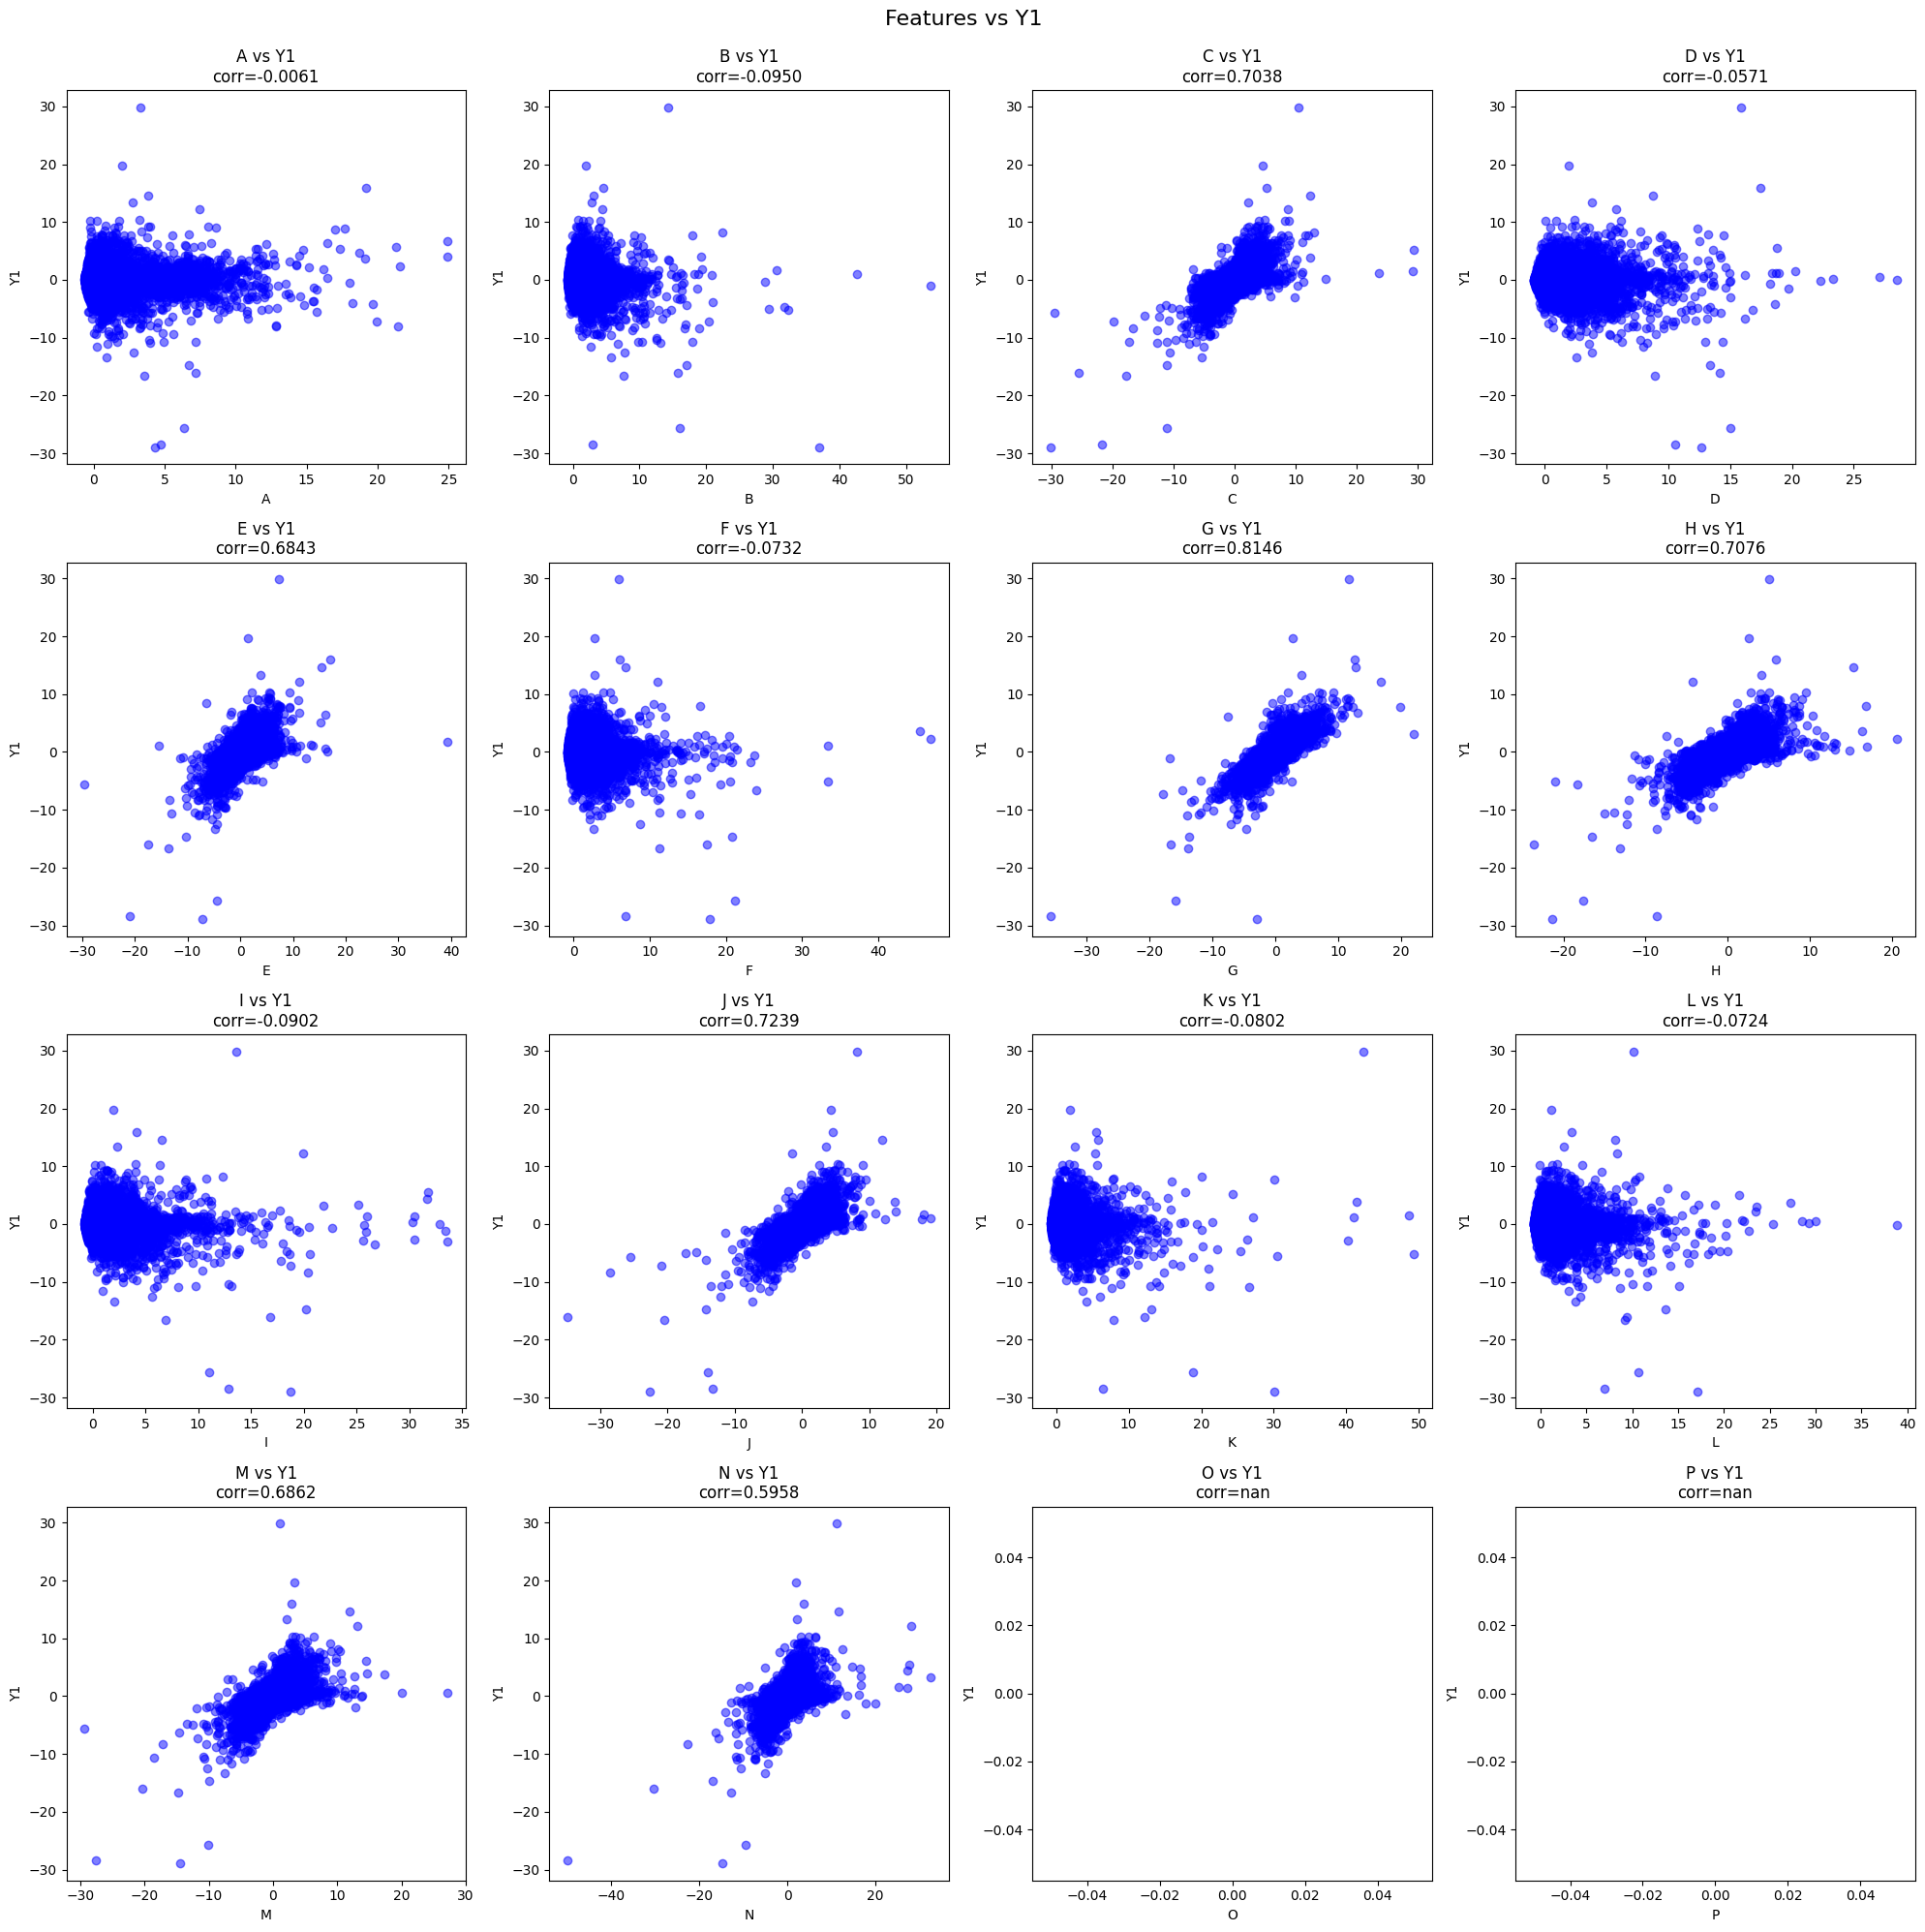

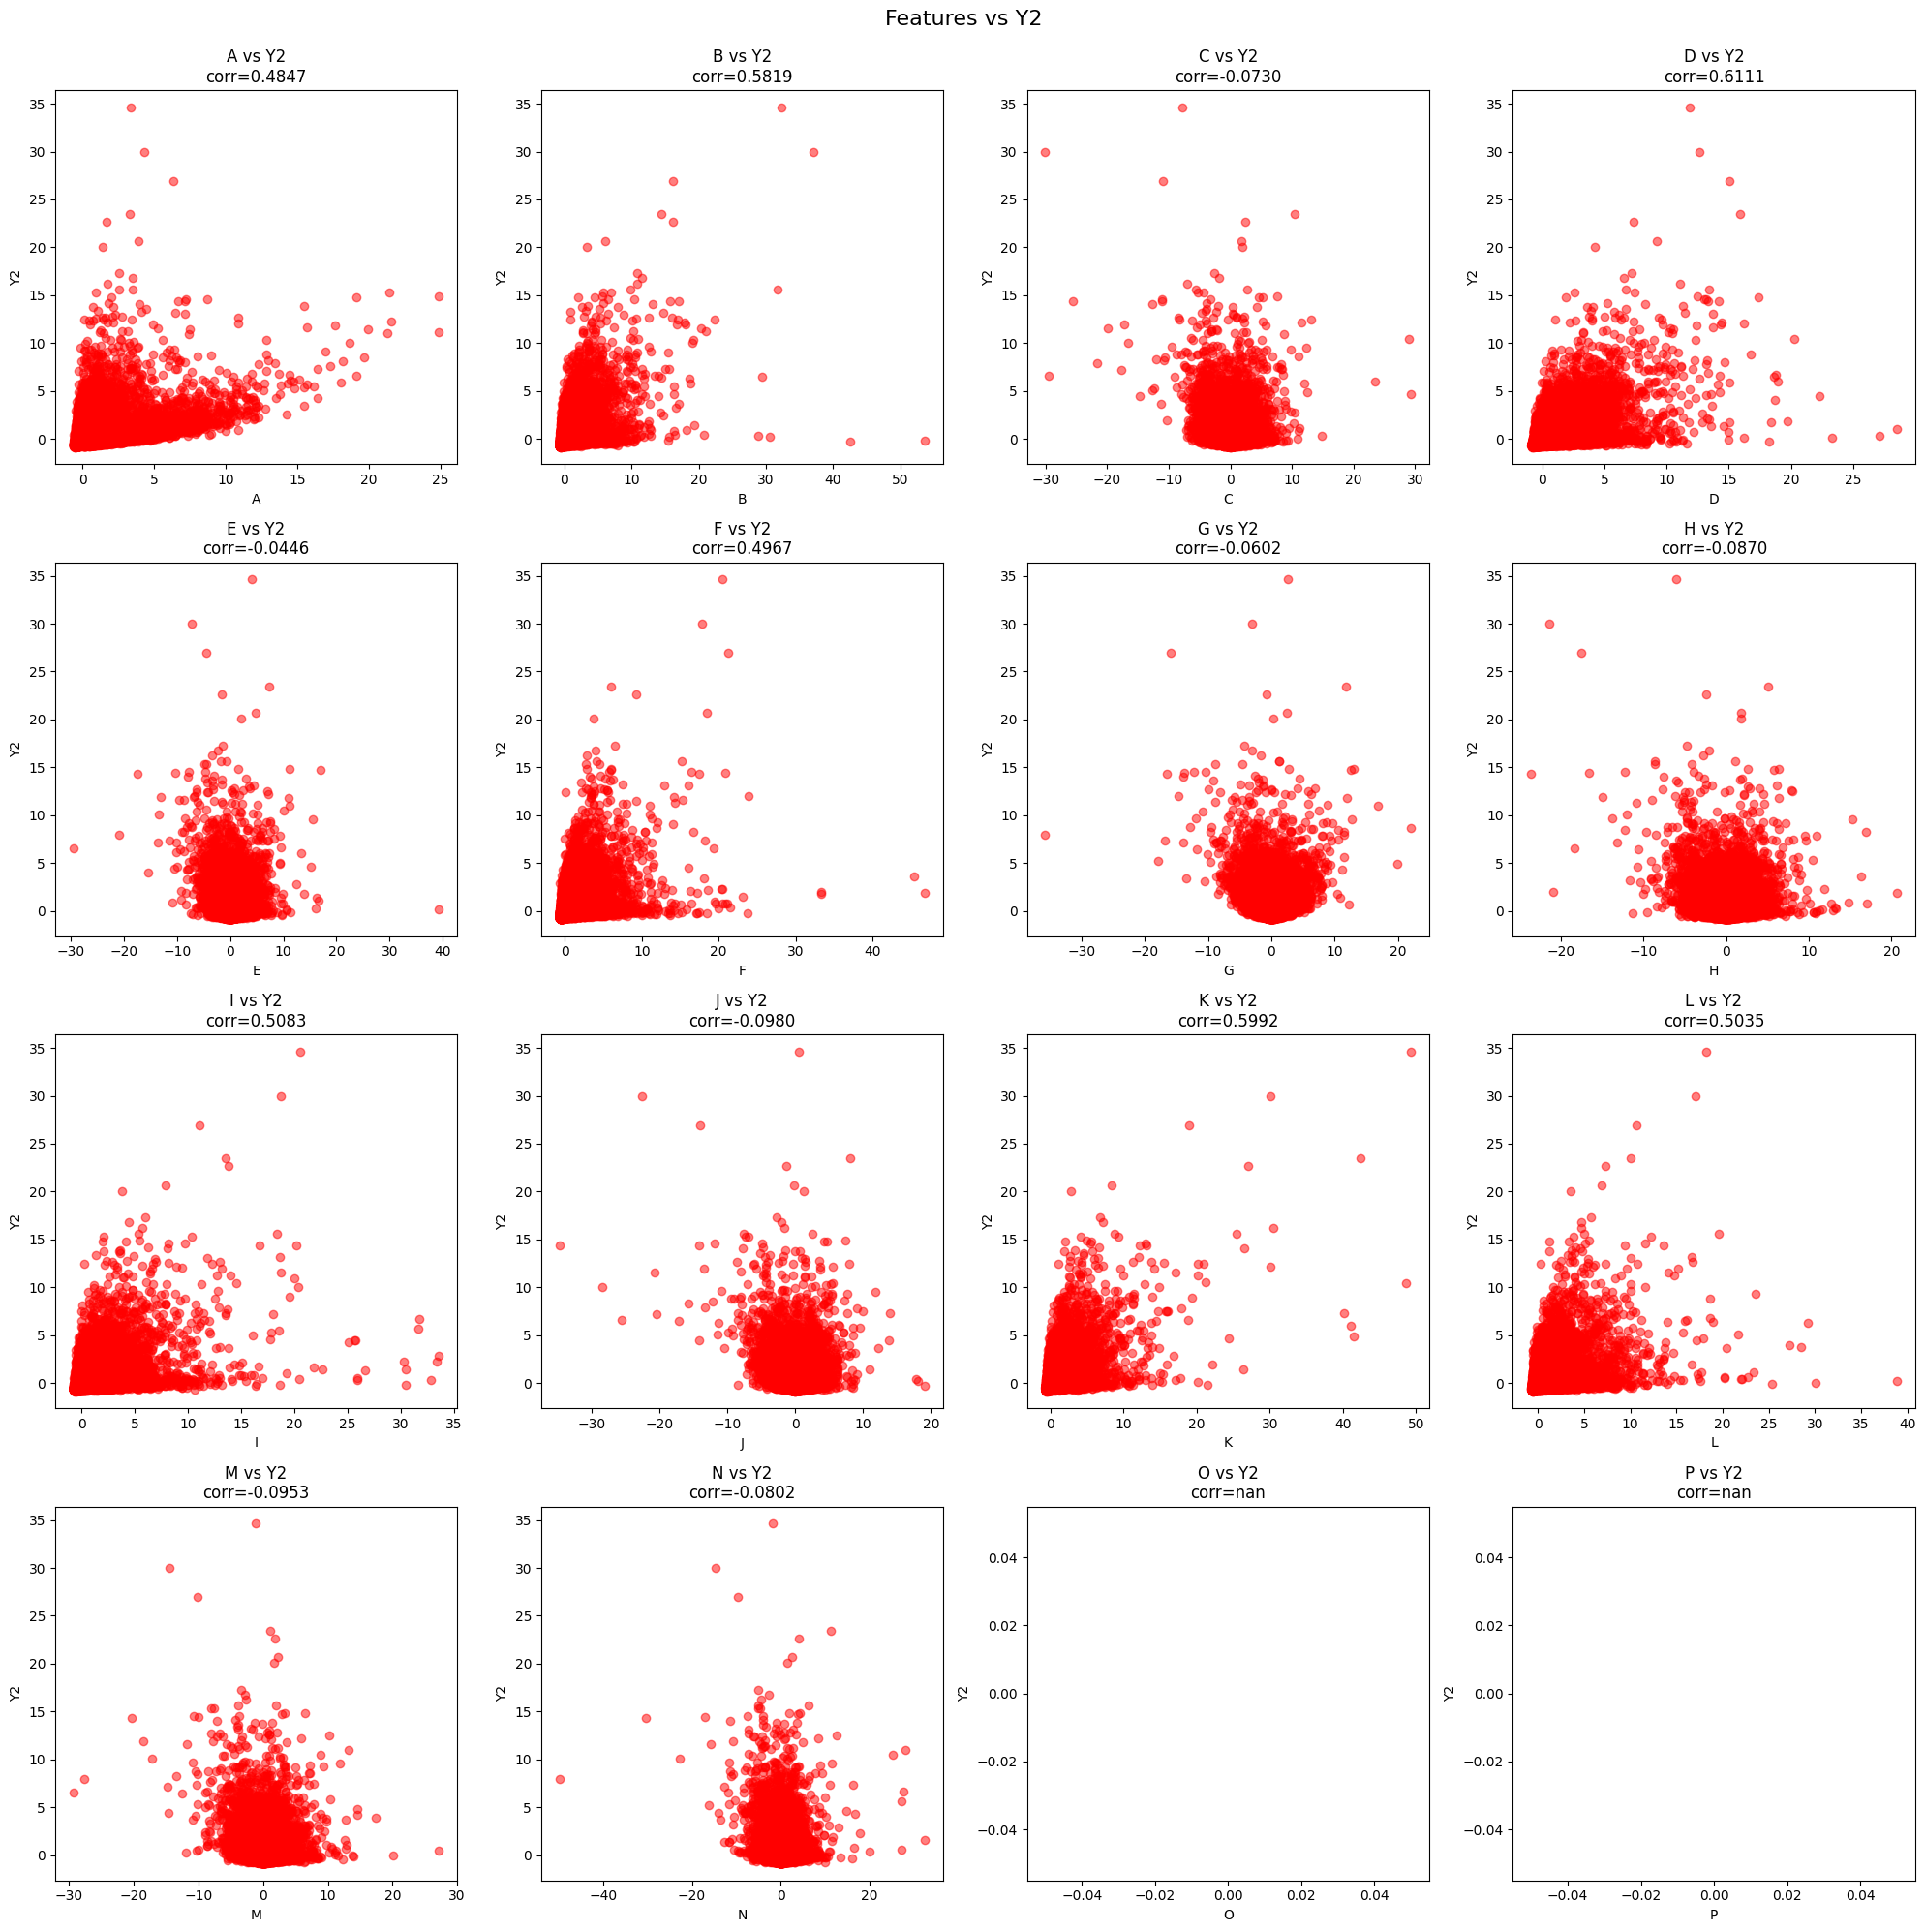

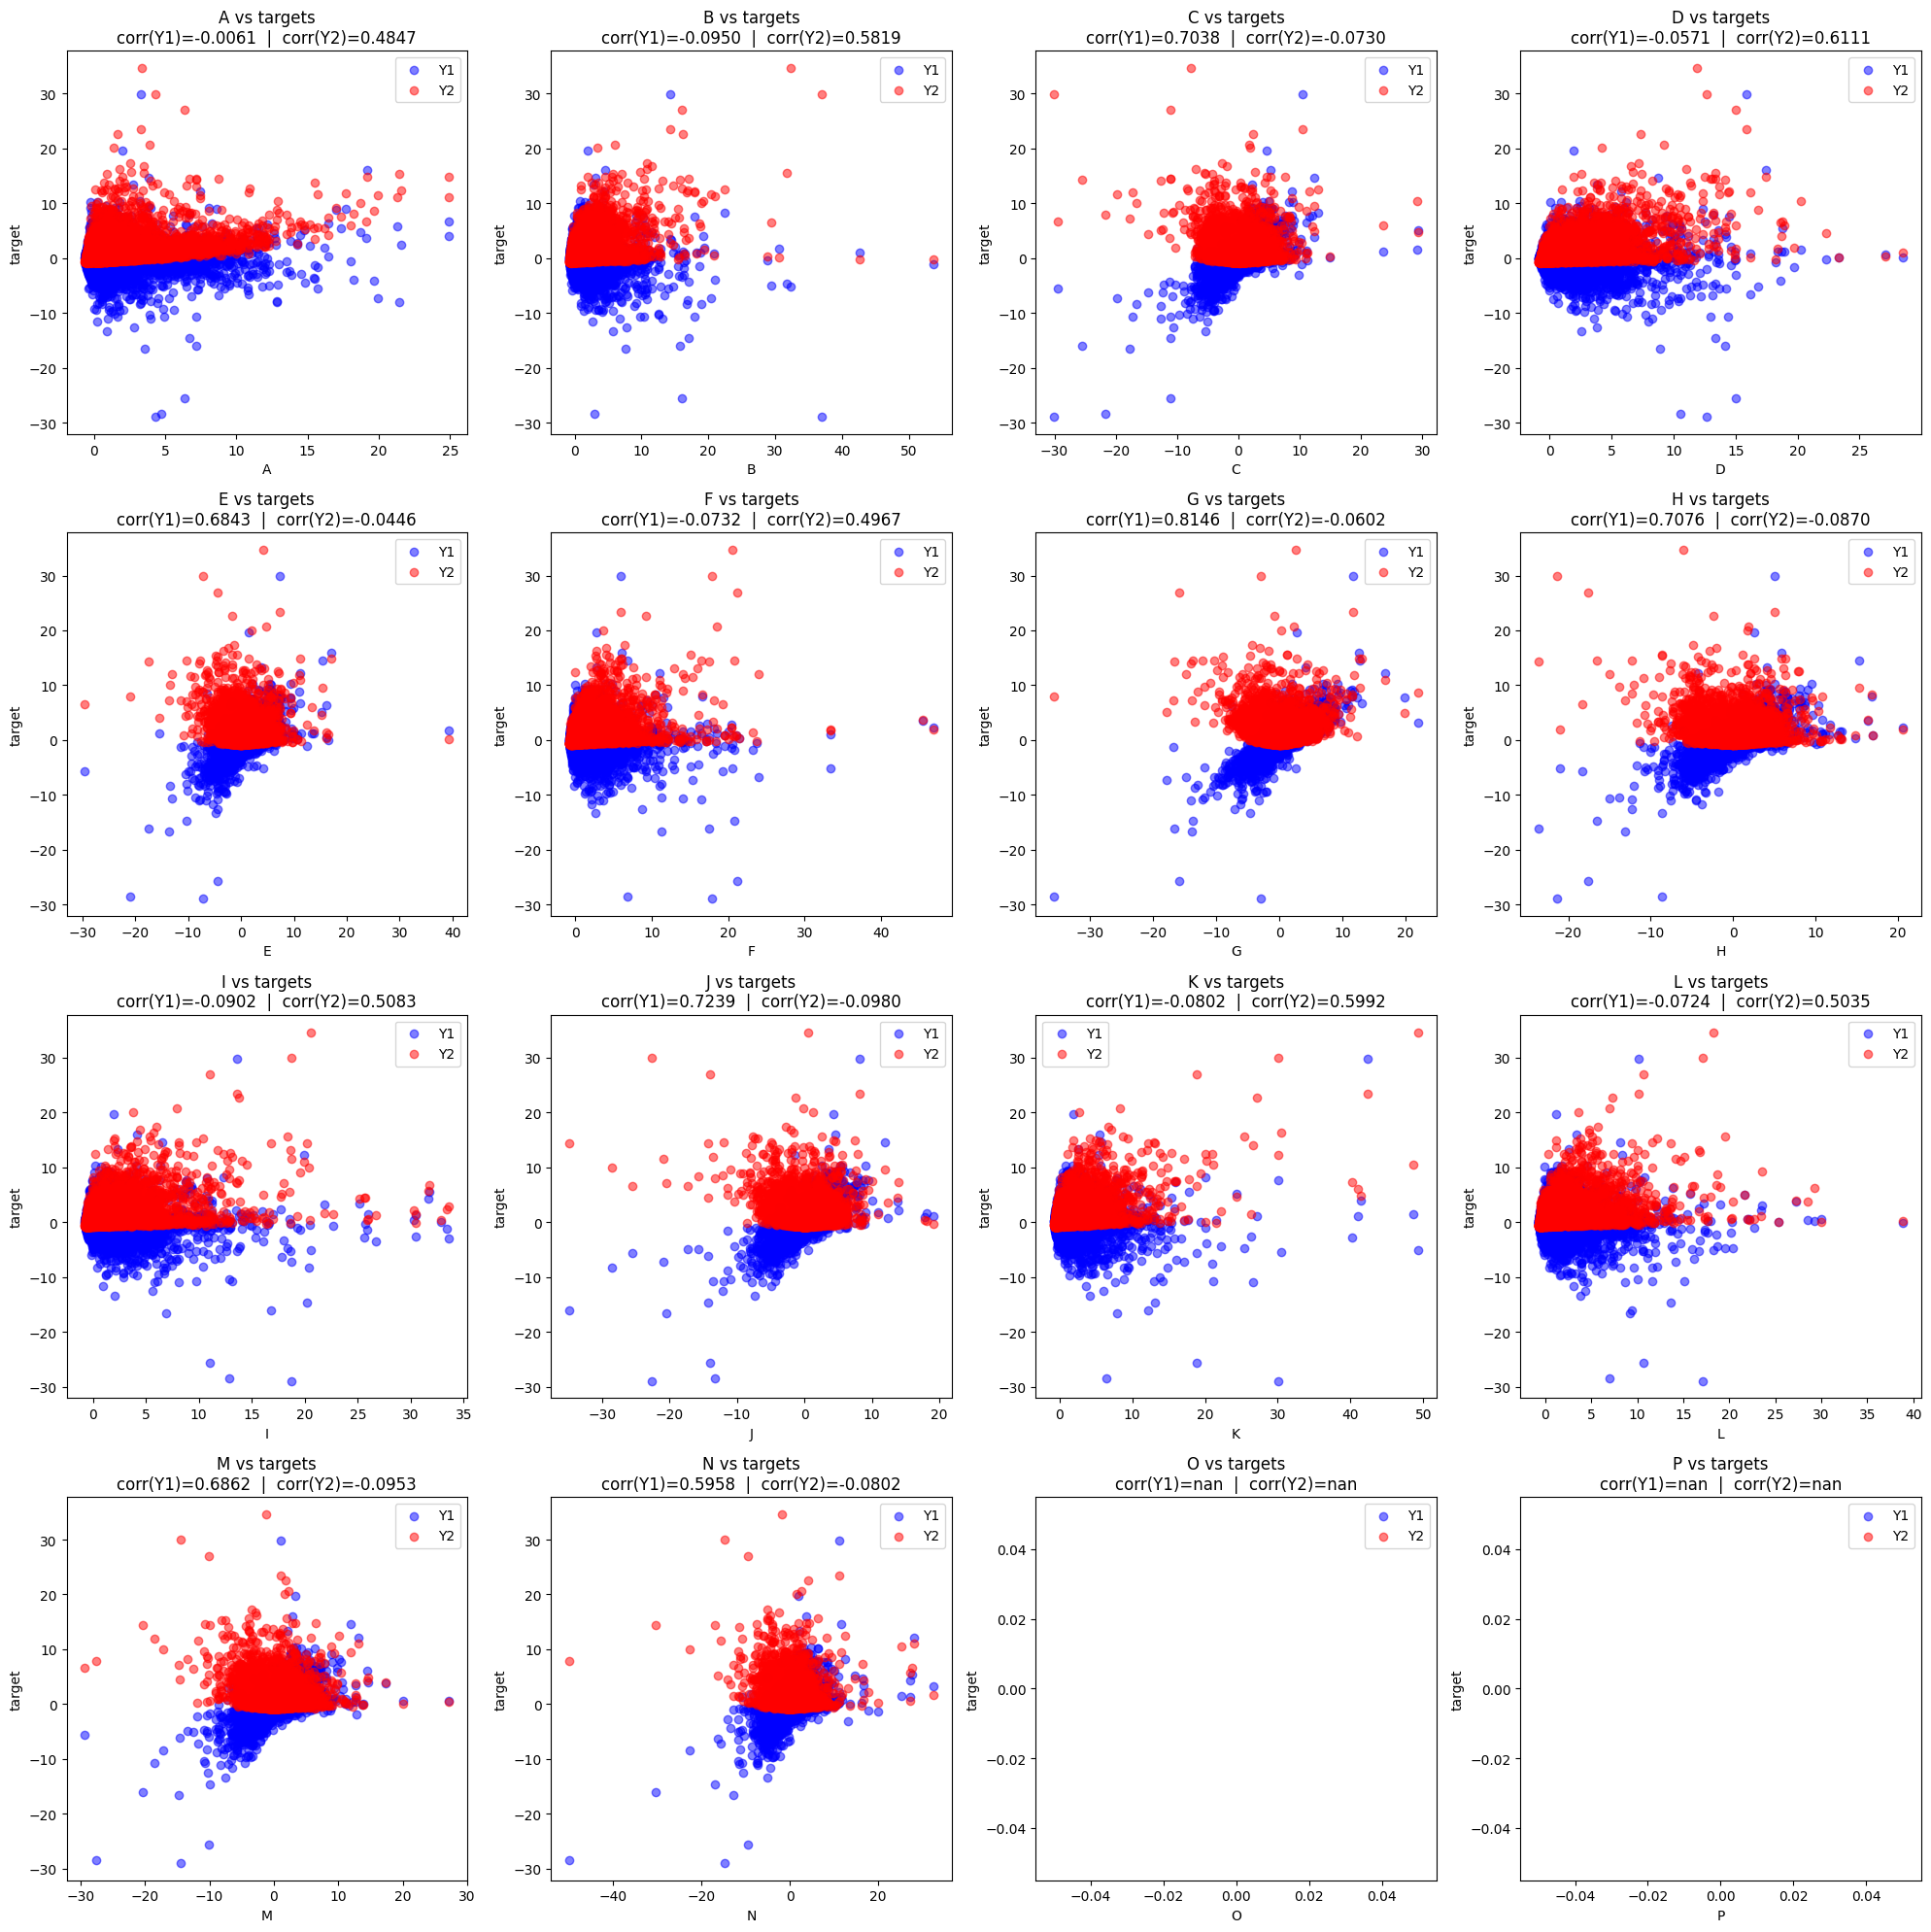

In [5]:
columns_to_plot = [c for c in columns if c not in ['time', 'Y1', 'Y2']]
num_cols = 4
num_rows = -(-len(columns_to_plot) // num_cols)
list_targets = [train_data["Y1"].to_numpy(),train_data["Y2"].to_numpy()]

correlation_dict_Y1 = plot_grid_vs_target(list_targets[0], "Y1", num_rows, num_cols, columns_to_plot, "blue")
print("\n")
correlation_dict_Y2 = plot_grid_vs_target(list_targets[1], "Y2", num_rows, num_cols, columns_to_plot, "red")
print("\n")
superpose_grids(list_targets, ["Y1","Y2"], num_rows, num_cols, columns_to_plot, ["blue","red"])

Compute Pearson correlation to assess linear relationship between the targets and the explanatory variables:

In [6]:
correlation_df = pd.DataFrame({
    'Correlation Y1': pd.Series(correlation_dict_Y1, dtype=float),
    'Correlation Y2': pd.Series(correlation_dict_Y2, dtype=float),
})
correlation_df = correlation_df.fillna(0.0)

# Helpful derived columns
correlation_df['abs_Y1'] = correlation_df['Correlation Y1'].abs()
correlation_df['abs_Y2'] = correlation_df['Correlation Y2'].abs()

# Combined strength (L2 norm of the two correlation coefficients)
correlation_df['score_l2'] = np.hypot(
    correlation_df['Correlation Y1'],
    correlation_df['Correlation Y2']
)

# Other combined scorings (pick the one you like)
correlation_df['score_max'] = correlation_df[['abs_Y1', 'abs_Y2']].max(axis=1)
correlation_df['score_mean'] = correlation_df[['abs_Y1', 'abs_Y2']].mean(axis=1)

# 1) Best features for Y1 (by absolute correlation with Y1)
top_by_Y1 = correlation_df.sort_values('abs_Y1', ascending=False)

# 2) Best features for Y2 (by absolute correlation with Y2)
top_by_Y2 = correlation_df.sort_values('abs_Y2', ascending=False)

# 3) Best overall considering both targets (L2 norm)
top_by_both = correlation_df.sort_values('score_l2', ascending=False).reset_index()
top_by_both = top_by_both.rename(columns={"index": "feature"})
pl_df = pl.from_pandas(top_by_both)

# Show results
print("Top by both (L2):\n")
print(pl_df.head(20))

Top by both (L2):

shape: (16, 8)
┌─────────┬───────────────┬──────────────┬──────────┬──────────┬──────────┬───────────┬────────────┐
│ feature ┆ Correlation   ┆ Correlation  ┆ abs_Y1   ┆ abs_Y2   ┆ score_l2 ┆ score_max ┆ score_mean │
│ ---     ┆ Y1            ┆ Y2           ┆ ---      ┆ ---      ┆ ---      ┆ ---       ┆ ---        │
│ str     ┆ ---           ┆ ---          ┆ f64      ┆ f64      ┆ f64      ┆ f64       ┆ f64        │
│         ┆ f64           ┆ f64          ┆          ┆          ┆          ┆           ┆            │
╞═════════╪═══════════════╪══════════════╪══════════╪══════════╪══════════╪═══════════╪════════════╡
│ G       ┆ 0.814568      ┆ -0.060187    ┆ 0.814568 ┆ 0.060187 ┆ 0.816788 ┆ 0.814568  ┆ 0.437377   │
│ J       ┆ 0.723921      ┆ -0.097986    ┆ 0.723921 ┆ 0.097986 ┆ 0.730522 ┆ 0.723921  ┆ 0.410953   │
│ H       ┆ 0.70756       ┆ -0.086976    ┆ 0.70756  ┆ 0.086976 ┆ 0.712885 ┆ 0.70756   ┆ 0.397268   │
│ C       ┆ 0.703823      ┆ -0.073009    ┆ 0.703823 ┆ 0.0

Many feature–target relations in the scatter plots look non-linear, so Pearson (linear) correlation can miss signal. Alternatives:
- Spearman's rho: rank-based; captures monotonic but non-linear relationships.
- Kendall's tau: rank-based; more robust to outliers but slower on large data.
- Mutual information (MI): model-free dependency measure; captures arbitrary non-linear relations (non-negative).
- Distance correlation / MIC (optional): require extra packages (e.g., `dcor`, `minepy`), useful for complex dependencies.

Below, compute Spearman, Kendall, and MI for each feature vs `Y1` and `Y2`, then rank features by these scores.

In [7]:
def rank_corr_series(X_col, y, method):
    m = X_col.notna() & y.notna()
    if m.sum() < 3:
        return np.nan
    if method == 'spearman':
        rho, _ = spearmanr(X_col[m], y[m])
        return rho
    elif method == 'kendall':
        tau, _ = kendalltau(X_col[m], y[m])
        return tau
    else:
        raise ValueError('method must be spearman or kendall')

In [8]:
# Prepare X (features) and y1, y2
feature_cols = [c for c in train_data.columns if c not in ['Y1', 'Y2']]
X = merged_data[feature_cols]
y1 = merged_data['Y1']
y2 = merged_data['Y2']

# Spearman and Kendall for all features
spearman_y1 = {c: rank_corr_series(X[c], y1, 'spearman') for c in feature_cols}
spearman_y2 = {c: rank_corr_series(X[c], y2, 'spearman') for c in feature_cols}
kendall_y1 = {c: rank_corr_series(X[c], y1, 'kendall') for c in feature_cols}
kendall_y2 = {c: rank_corr_series(X[c], y2, 'kendall') for c in feature_cols}

# Mutual Information (MI): requires numeric inputs; fill remaining NaNs to avoid failure
X_num = X.select_dtypes(include=['number']).copy()
# Minimal imputation (median) just for MI computation
X_num = X_num.fillna(X_num.median(numeric_only=True))
y1_filled = y1.fillna(y1.median())
y2_filled = y2.fillna(y2.median())

mi_y1 = mutual_info_regression(X_num.values, y1_filled.values, random_state=0)
mi_y2 = mutual_info_regression(X_num.values, y2_filled.values, random_state=0)
mi_y1 = pd.Series(mi_y1, index=X_num.columns)
mi_y2 = pd.Series(mi_y2, index=X_num.columns)

# Assemble results into a DataFrame
nl_df = pd.DataFrame({
    'spearman_Y1': pd.Series(spearman_y1),
    'spearman_Y2': pd.Series(spearman_y2),
    'kendall_Y1': pd.Series(kendall_y1),
    'kendall_Y2': pd.Series(kendall_y2),
}).fillna(0.0)

# Insert MI columns (only for numeric features) and fill others with 0
nl_df['MI_Y1'] = 0.0
nl_df['MI_Y2'] = 0.0
for col in X_num.columns:
    nl_df.loc[col, 'MI_Y1'] = mi_y1[col]
    nl_df.loc[col, 'MI_Y2'] = mi_y2[col]

# Build combined ranking scores
nl_df['rank_strength_Y1'] = nl_df['spearman_Y1'].abs().rank(ascending=False, method='average')
nl_df['rank_strength_Y2'] = nl_df['spearman_Y2'].abs().rank(ascending=False, method='average')
nl_df['rank_MI_Y1'] = nl_df['MI_Y1'].rank(ascending=False, method='average')
nl_df['rank_MI_Y2'] = nl_df['MI_Y2'].rank(ascending=False, method='average')
nl_df['rank_overall'] = (nl_df['rank_strength_Y1'] + nl_df['rank_MI_Y1'] + nl_df['rank_strength_Y2'] + nl_df['rank_MI_Y2']) / 4.0
nl_df_reset = nl_df.reset_index()
nl_df_reset = nl_df_reset.rename(columns={"index": "feature"})
nl_pl = pl.from_pandas(nl_df_reset)
print("CORRELATIONS WITH RANKING")
print(nl_pl)

# Sort views
top_spearman_Y1 = pl.from_pandas(nl_df.sort_values('spearman_Y1', key=lambda s: s.abs(), ascending=False).head(20).reset_index().rename(columns={"index": "feature"}))
top_spearman_Y2 =  pl.from_pandas(nl_df.sort_values('spearman_Y2', key=lambda s: s.abs(), ascending=False).head(20).reset_index().rename(columns={"index": "feature"}))
top_mi_Y1 =  pl.from_pandas(nl_df.sort_values('MI_Y1', ascending=False).head(20).reset_index().rename(columns={"index": "feature"}))
top_mi_Y2 =  pl.from_pandas(nl_df.sort_values('MI_Y2', ascending=False).head(20).reset_index().rename(columns={"index": "feature"}))
top_overall =  pl.from_pandas(nl_df.sort_values('rank_overall').head(20).reset_index().rename(columns={"index": "feature"}))

print('\nTop Spearman (Y1):\n')
print(top_spearman_Y1[:,['feature','spearman_Y1']])
print('\nTop Spearman (Y2):\n')
print(top_spearman_Y2[:,['feature','spearman_Y2']])
print('\nTop Mutual Information (Y1):\n')
print(top_mi_Y1[:,['feature','spearman_Y1']])
print('\nTop Mutual Information (Y2):\n')
print(top_mi_Y2[:,['feature','spearman_Y2']])
print('\nTop Overall (avg rank of Spearman & MI for Y1 and Y2):\n')
print(top_overall[:,['feature','spearman_Y1','spearman_Y2']])

CORRELATIONS WITH RANKING
shape: (16, 12)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ feature ┆ spearman_Y ┆ spearman_ ┆ kendall_Y ┆ … ┆ rank_stre ┆ rank_MI_Y ┆ rank_MI_Y ┆ rank_over │
│ ---     ┆ 1          ┆ Y2        ┆ 1         ┆   ┆ ngth_Y2   ┆ 1         ┆ 2         ┆ all       │
│ str     ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ f64        ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ A       ┆ -0.002308  ┆ 0.609209  ┆ -0.00138  ┆ … ┆ 4.0       ┆ 13.0      ┆ 1.0       ┆ 8.0       │
│ B       ┆ -0.021435  ┆ 0.62362   ┆ -0.013819 ┆ … ┆ 2.0       ┆ 8.0       ┆ 3.0       ┆ 6.0       │
│ C       ┆ 0.695609   ┆ -0.00963  ┆ 0.522716  ┆ … ┆ 14.0      ┆ 4.0       ┆ 9.0       ┆ 8.0       │
│ D       ┆ -0.016948  ┆ 0.612065  ┆ -0.011279 ┆ 

### 4) Visualize Relationships among Explanatory Variables

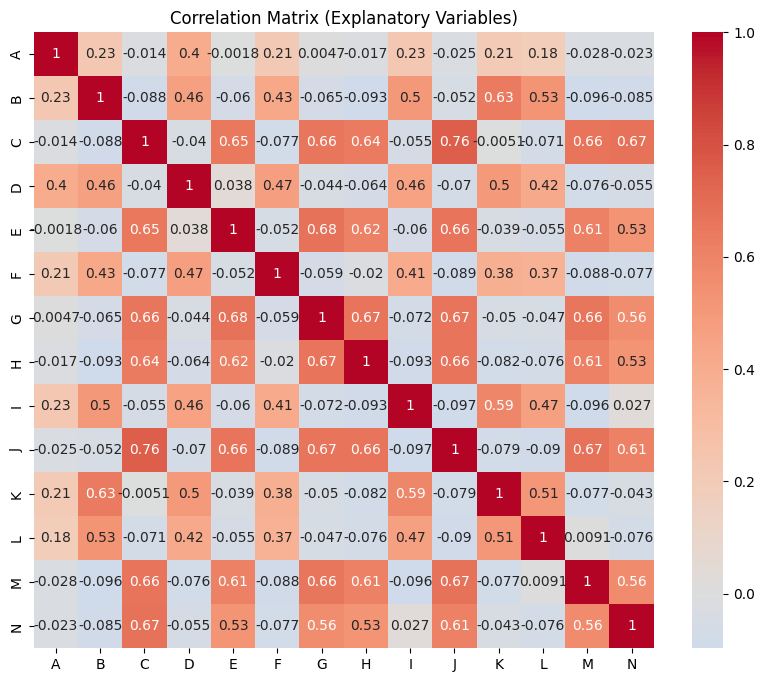

In [26]:
corr_matrix = train_data.to_pandas().drop(columns=["O","P","Y1", "Y2"]).corr(method="pearson")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Explanatory Variables)")
plt.show()

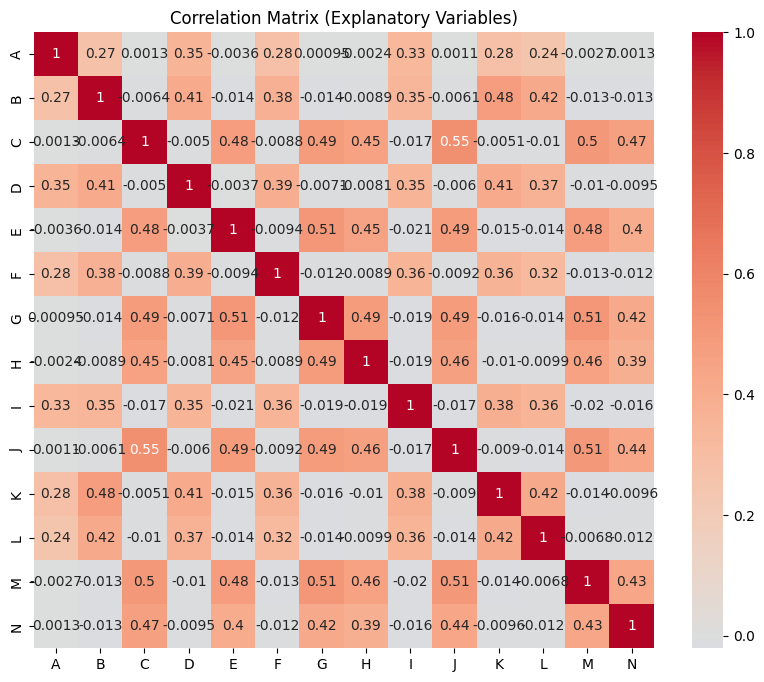

In [28]:
corr_matrix = train_data.to_pandas().drop(columns=["O","P","Y1", "Y2"]).corr(method="kendall")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Explanatory Variables)")
plt.show()

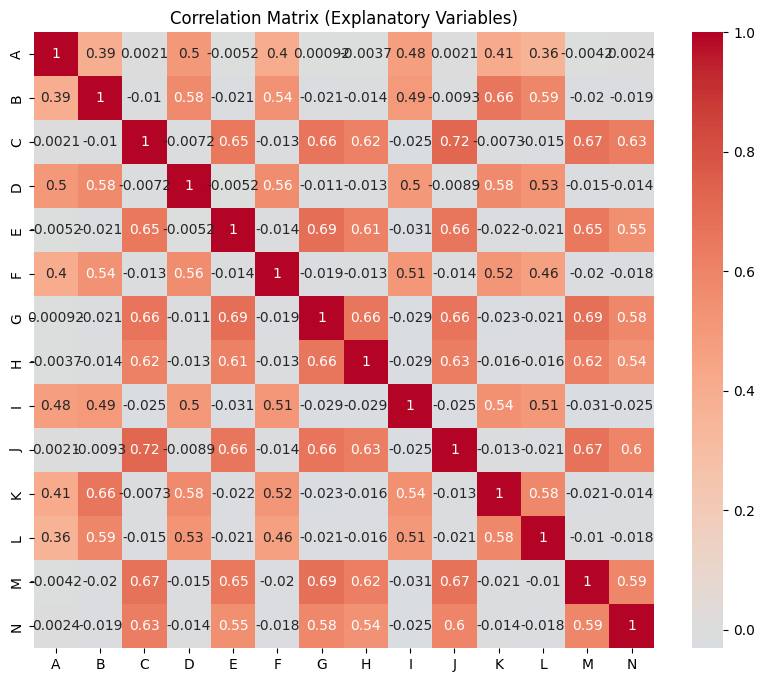

In [ ]:
pandas__mat = train_data.to_pandas()
corr_matrix = pandas_mat.drop(columns=["O","P","Y1", "Y2"]).corr(method="spearman")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Explanatory Variables)")
plt.show()

### 5) Visualize Distributions and Outliers

Now compute the histograms deleting the outlier to see distributions better

In [10]:
def generate_hist(df: pl.DataFrame, bins: int = 100, exclude: Optional[List[str]] = None, cols: int = 4, clip_mode: str = "quantile", q_low: float = 0.01, q_high: float = 0.99, iqr_k: float = 1.5, log_y: bool = False):
    if exclude is None:
            exclude = ["Y1", "Y2"]

    feature_cols = [c for c in df.columns if c not in exclude]
    n = len(feature_cols)

    cols = 4
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, col in enumerate(feature_cols):
        ax = axes[i]

        s = pd.to_numeric(df[col].to_pandas(), errors="coerce").dropna()
        if s.empty:
            ax.set_visible(False)
            continue

        if clip_mode == "quantile":
            low, high = s.quantile(q_low), s.quantile(q_high)
        else:  # IQR
            q1, q3 = s.quantile(0.25), s.quantile(0.75)
            iqr = q3 - q1
            low, high = q1 - iqr_k * iqr, q3 + iqr_k * iqr

        s_clipped = s[(s >= low) & (s <= high)]
        clipped_pct = 0.0 if len(s) == 0 else 100.0 * (1.0 - len(s_clipped) / len(s))

        ax.hist(s_clipped,bins=bins,color="steelblue",alpha=0.9,edgecolor="white",density=True)

        ax.set_title(
            f"Histogram of {col}\n[{low:.3g}, {high:.3g}] | outlier pct {clipped_pct:.3f}%"
        )
        ax.set_xlabel(col)
        ax.set_ylabel("Density")
        ax.set_xlim(low, high)

        if log_y:
            ax.set_yscale("log")

    for j in range(n, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def fit_distributions(df: pl.DataFrame, columns=None, distributions=None,bins=100,top_k=3):
    if columns is None:
        columns = [c for c, dt in zip(df.columns, df.dtypes) if dt.is_numeric()]
    
    results = {}

    for col in columns:
        x = df[col].drop_nulls().to_numpy()
        if len(x) < 50 or np.std(x) == 0:
            continue

        f = Fitter(x, distributions=distributions, bins=bins)
        f.fit()

        f.summary(Nbest=top_k)
        results[col] = f

    return results

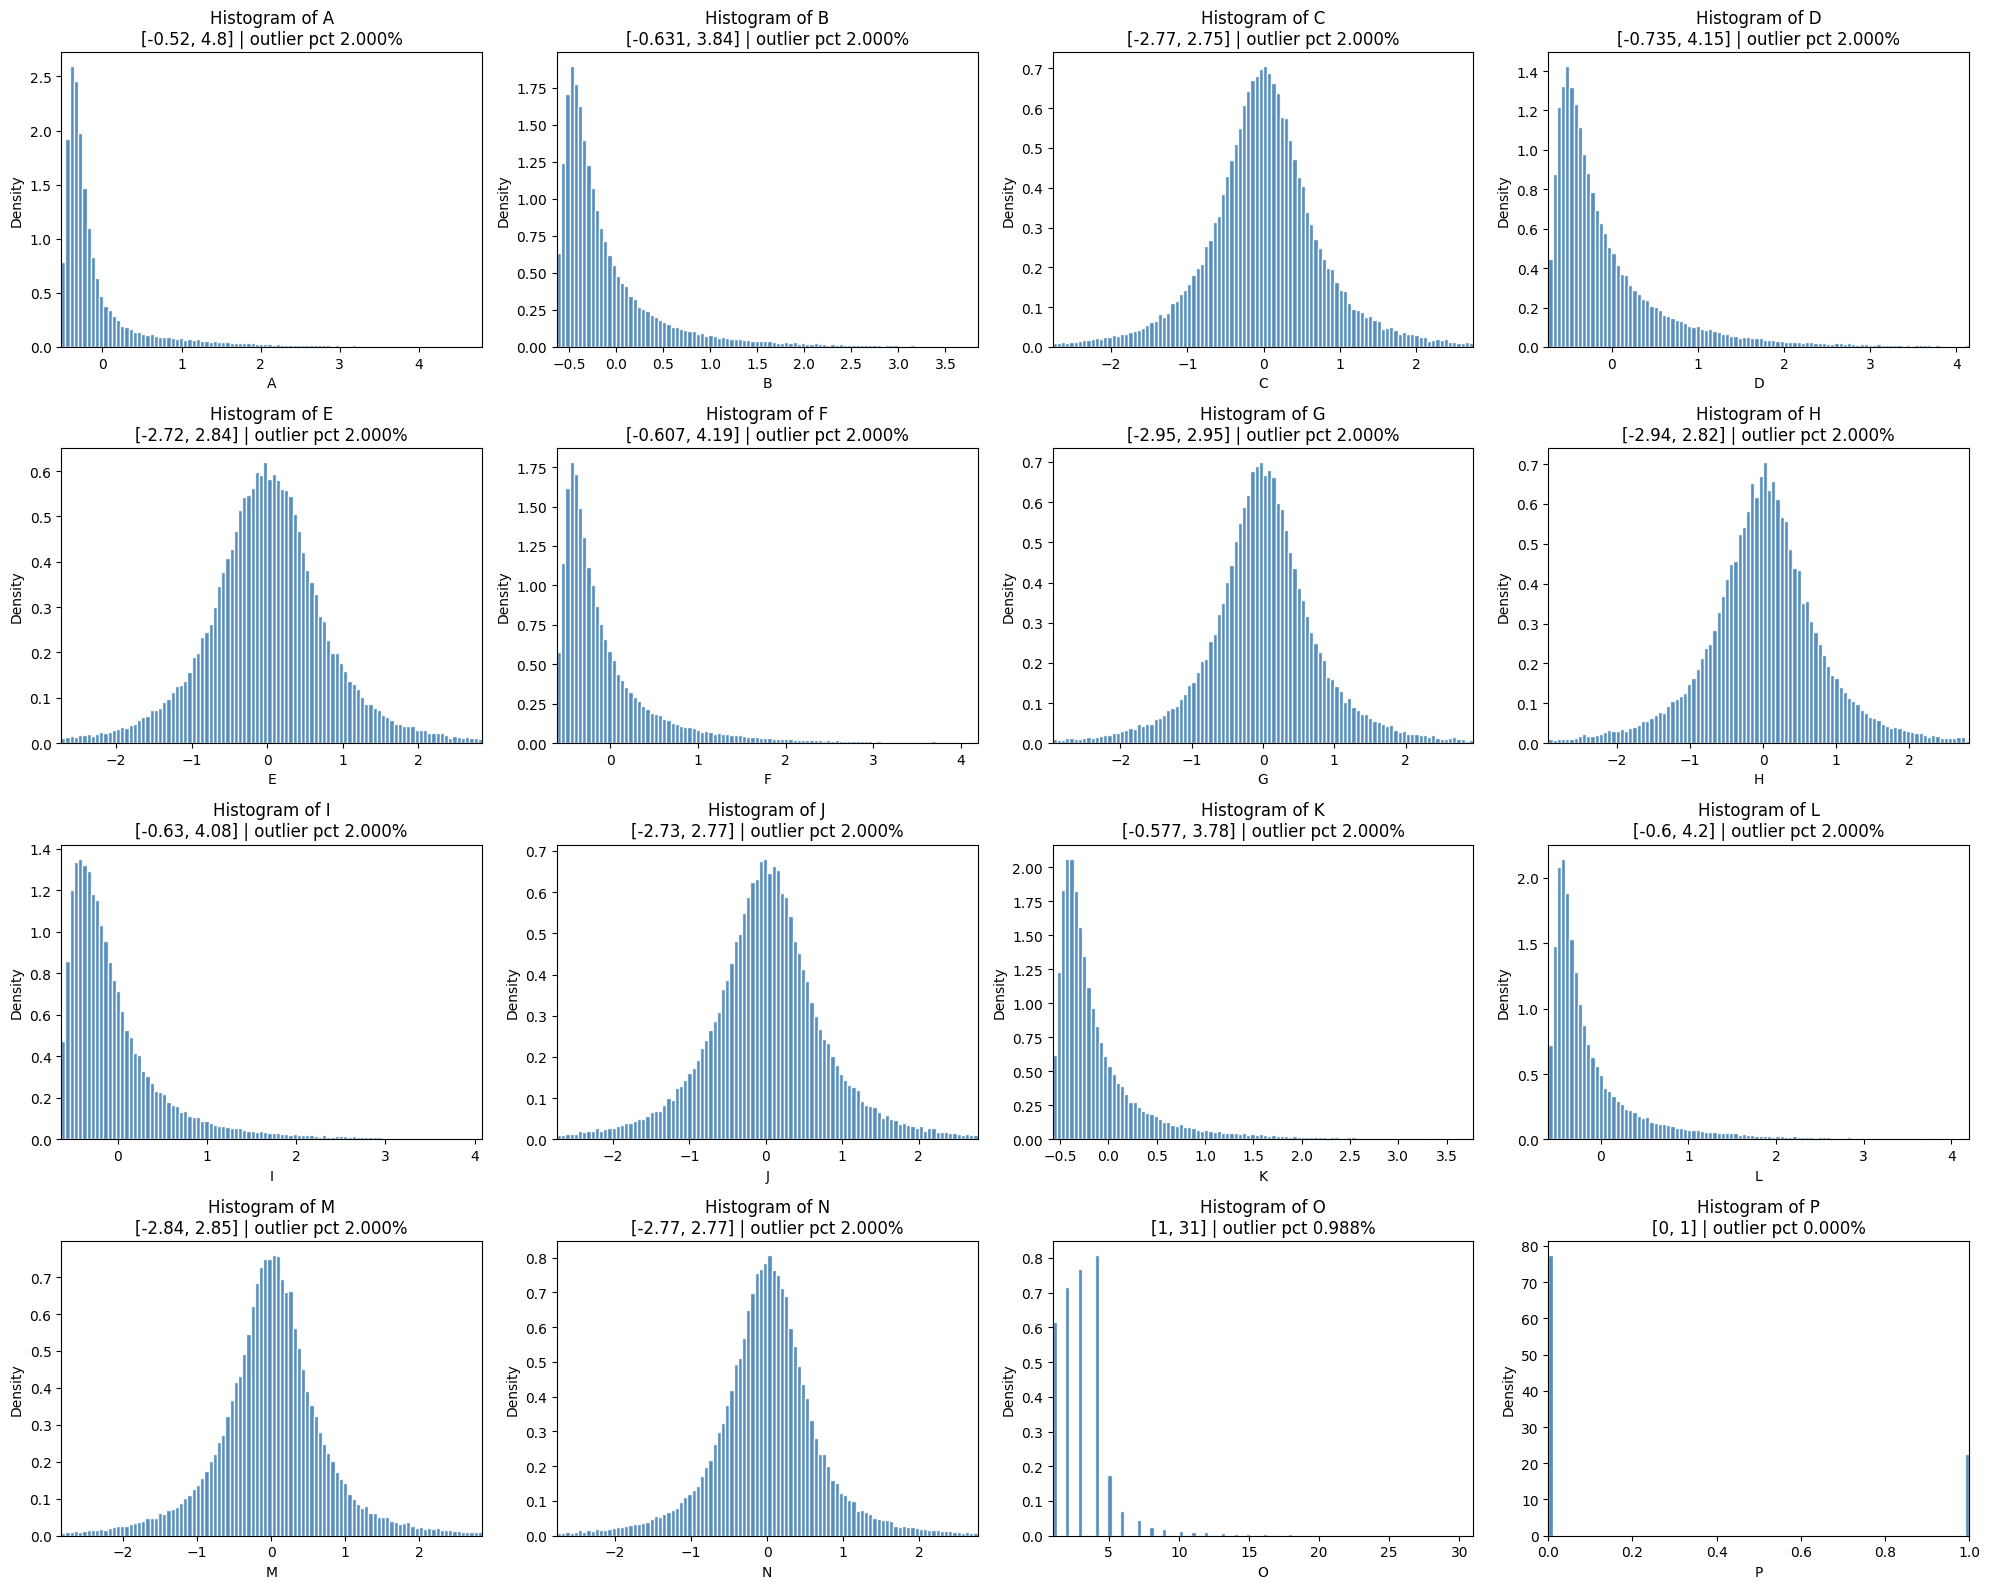

In [27]:
generate_hist(train_data, log_y=False)